In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import BertTokenizer
from transformers import RobertaTokenizer
# from transformers import GPT2TokenizerFast
from transformers import AlbertTokenizer
from transformers import DistilBertTokenizer
from transformers import TrainingArguments, Trainer
from transformers import BertForSequenceClassification
from transformers import RobertaForSequenceClassification
# from transformers import GPT2ForSequenceClassification
from transformers import AlbertForSequenceClassification
from transformers import DistilBertForSequenceClassification

/Users/mstudio/miniconda3/envs/py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from tqdm import tqdm
# import nltk
# stop=nltk.corpus.stopwords.words('english')
# from nltk import word_tokenize
# import stanza
# nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,lemma')
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

In [5]:
org=pd.read_csv('/Volumes/T7/mt-hemingway/data/classification/small.csv')
org=org.dropna()
OPUS_big=pd.read_csv('/Volumes/T7/mt-hemingway/data/classification/cross_model_language/KO1/M2M100_KO_big.csv')
OPUS_big=OPUS_big.dropna()

In [6]:
print(org.shape, OPUS_big.shape)

(768, 2) (768, 2)


In [7]:
frames=[org.sample(org.shape[0]), OPUS_big.sample(OPUS_big.shape[0])]
data=pd.concat(frames)

In [6]:
def lemmatization(df: pd.DataFrame(), col: str):
    df[col]=df[col].str.lower()
    df[col+'_'+'stopwods']=df[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df[col+'_'+'punct']=df[col+'_'+'stopwods'].str.replace('[^\w\s]','')
    # df[col+'_'+'lower']=df[col+'_'+'punct'].str.lower()
    try: 
        df[col+'_'+'lemma']=df[col+'_'+'punct'].apply(lambda x: ' '.join(w.lemma for sent in nlp(str(x)).sentences for w in sent.words))
    except:
        df[col+'_'+'lemma']=df[col+'_'+'punct']
    return df

In [17]:
# data=lemmatization(data, 'text')

In [8]:
data['label'].groupby(data['label']).count()

label
M2M100_to_KO_big    768
small               768
Name: label, dtype: int64

In [9]:
data['label']=data['label'].replace({data['label'].groupby(data['label']).count().keys()[0]:0, data['label'].groupby(data['label']).count().keys()[1]:1})

In [10]:
%%time
X=list(data['text'])
y=list(data['label'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

CPU times: user 1.81 ms, sys: 888 µs, total: 2.7 ms
Wall time: 1.95 ms


In [33]:
bert_tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')
roberta_tokenizer=RobertaTokenizer.from_pretrained('roberta-base')
# gpt_tokenizer=GPT2TokenizerFast.from_pretrained('gpt2')
albert_tokenizer=AlbertTokenizer.from_pretrained('albert-base-v2')
distilbert_tokenizer=DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# kobert_tokenizer=KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
# roberta_tokenizer=BertTokenizer.from_pretrained('roberta-base')
bert_model=BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
roberta_model=RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
# gpt_model=GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)
albert_model=AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)
distilbert_model=DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
from kobert_tokenizer import KoBERTTokenizer
kobert_tokenizer=KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
kobert_model=BertForSequenceClassification.from_pretrained('skt/kobert-base-v1', num_labels=2)
warnings.filterwarnings('ignore')

loading file vocab.txt from cache at /Users/mstudio/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/mstudio/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /Users/mstudio/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_

ModuleNotFoundError: No module named 'kobert_tokenizer'

In [12]:
device=torch.device('mps')
bert_model.to(device)
roberta_model.to(torch.device('cpu'))
# gpt_model.to(torch.device('cpu'))
albert_model.to(torch.device('cpu'))
distilbert_model.to(torch.device('cpu'))
device

device(type='mps')

In [13]:
X_train_tokenized_bert=bert_tokenizer(X_train, padding=True, truncation=True)#, max_length=512)
X_test_tokenized_bert=bert_tokenizer(X_test, padding=True, truncation=True)#, max_lenght=512)
X_train_tokenized_roberta=roberta_tokenizer(X_train, padding=True, truncation=True)#, max_length=512)
X_test_tokenized_roberta=roberta_tokenizer(X_test, padding=True, truncation=True)#, max_lenght=512)
# X_train_tokenized_gpt=gpt_tokenizer(X_train, truncation=True)#, max_length=512)
# X_test_tokenized_gpt=gpt_tokenizer(X_test, truncation=True)#, max_lenght=512)
X_train_tokenized_albert=albert_tokenizer(X_train, padding=True, truncation=True)#, max_length=512)
X_test_tokenized_albert=albert_tokenizer(X_test, padding=True, truncation=True)#, max_lenght=512)
X_train_tokenized_distilbert=distilbert_tokenizer(X_train, padding=True, truncation=True)#, max_length=512)
X_test_tokenized_distilbert=distilbert_tokenizer(X_test, padding=True, truncation=True)#, max_lenght=512)

In [14]:
X_train_tokenized_bert.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

<AxesSubplot: >

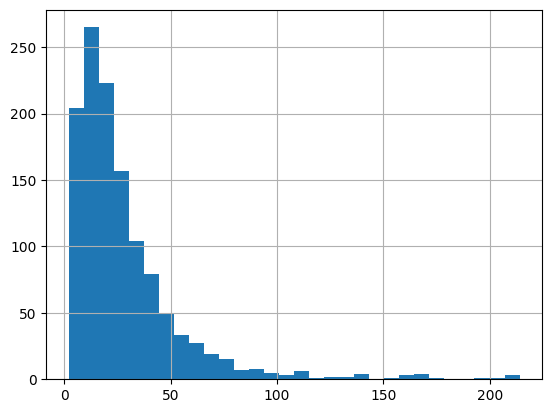

In [16]:
seq_len = [len(i.split()) for i in X_train]
pd.Series(seq_len).hist(bins = 30)

https://huggingface.co/transformers/v3.2.0/custom_datasets.html

In [14]:
#create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [15]:
train_dataset_bert=Dataset(X_train_tokenized_bert, y_train)
test_dataset_bert=Dataset(X_test_tokenized_bert, y_test)
train_dataset_roberta=Dataset(X_train_tokenized_roberta, y_train)
test_dataset_roberta=Dataset(X_test_tokenized_roberta, y_test)
# train_dataset_gpt=Dataset(X_train_tokenized_gpt, y_train)
# test_dataset_gpt=Dataset(X_test_tokenized_gpt, y_test)
train_dataset_albert=Dataset(X_train_tokenized_albert, y_train)
test_dataset_albert=Dataset(X_test_tokenized_albert, y_test)
train_dataset_distilbert=Dataset(X_train_tokenized_distilbert, y_train)
test_dataset_distilbert=Dataset(X_test_tokenized_distilbert, y_test)

In [16]:
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred=np.argmax(pred, axis=1)
    accuracy=accuracy_score(y_true=labels, y_pred=pred)
    recall=recall_score(y_true=labels, y_pred=pred)
    precision=precision_score(y_true=labels, y_pred=pred)
    f1=f1_score(y_true=labels, y_pred=pred)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

In [17]:
#define Trainer
args_bert=TrainingArguments(
    output_dir='output',
    num_train_epochs=1,#higher may get the higer accuracy
    per_device_train_batch_size=8,
    use_mps_device=True
)
trainer_bert=Trainer(
    model=bert_model,
    args=args_bert,
    train_dataset=train_dataset_bert,
    eval_dataset=test_dataset_bert,
    compute_metrics=compute_metrics,
)

In [21]:
args_roberta=TrainingArguments(
    output_dir='output',
    num_train_epochs=1,#higher may get the higer accuracy
    per_device_train_batch_size=8,
    # use_mps_device=True,
    # pytorch_device='cpu',
)
trainer_roberta=Trainer(
    model=roberta_model,
    args=args_roberta,
    train_dataset=train_dataset_roberta,
    eval_dataset=test_dataset_roberta,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [21]:
# args_gpt=TrainingArguments(
#     output_dir='output',
#     num_train_epochs=1,#higher may get the higer accuracy
#     per_device_train_batch_size=8,
#     use_mps_device=True,
    
# )
# trainer_gpt=Trainer(
#     model=gpt_model,
#     args=args_gpt,
#     train_dataset=train_dataset_gpt,
#     eval_dataset=test_dataset_gpt,
#     compute_metrics=compute_metrics,
    
# )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [17]:
args_albert=TrainingArguments(
    output_dir='output',
    num_train_epochs=1,#higher may get the higer accuracy
    per_device_train_batch_size=8,
    use_mps_device=True
)
trainer_albert=Trainer(
    model=albert_model,
    args=args_albert,
    train_dataset=train_dataset_albert,
    eval_dataset=test_dataset_albert,
    compute_metrics=compute_metrics,
)

In [20]:
args_distilbert=TrainingArguments(
    output_dir='output',
    num_train_epochs=1,#higher may get the higer accuracy
    per_device_train_batch_size=8,
    use_mps_device=True
)
trainer_distilbert=Trainer(
    model=distilbert_model,
    args=args_distilbert,
    train_dataset=train_dataset_distilbert,
    eval_dataset=test_dataset_distilbert,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [18]:
trainer_bert.train()

***** Running training *****
  Num examples = 1228
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 154
  Number of trainable parameters = 109483778
100%|██████████| 154/154 [01:31<00:00,  1.79it/s]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 154/154 [01:31<00:00,  1.68it/s]

{'train_runtime': 91.4553, 'train_samples_per_second': 13.427, 'train_steps_per_second': 1.684, 'train_loss': 0.3879295943619369, 'epoch': 1.0}


TrainOutput(global_step=154, training_loss=0.3879295943619369, metrics={'train_runtime': 91.4553, 'train_samples_per_second': 13.427, 'train_steps_per_second': 1.684, 'train_loss': 0.3879295943619369, 'epoch': 1.0})

In [22]:
trainer_roberta.train()

***** Running training *****
  Num examples = 1228
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 154


  0%|          | 0/154 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 278.3091, 'train_samples_per_second': 4.412, 'train_steps_per_second': 0.553, 'train_loss': 0.4070694415600269, 'epoch': 1.0}


TrainOutput(global_step=154, training_loss=0.4070694415600269, metrics={'train_runtime': 278.3091, 'train_samples_per_second': 4.412, 'train_steps_per_second': 0.553, 'train_loss': 0.4070694415600269, 'epoch': 1.0})

In [44]:
# trainer_gpt.train()

In [18]:
trainer_albert.train()

***** Running training *****
  Num examples = 1228
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 154


  0%|          | 0/154 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 42.689, 'train_samples_per_second': 28.766, 'train_steps_per_second': 3.607, 'train_loss': 0.36550908274464794, 'epoch': 1.0}


TrainOutput(global_step=154, training_loss=0.36550908274464794, metrics={'train_runtime': 42.689, 'train_samples_per_second': 28.766, 'train_steps_per_second': 3.607, 'train_loss': 0.36550908274464794, 'epoch': 1.0})

In [21]:
trainer_distilbert.train()

***** Running training *****
  Num examples = 1228
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 154


  0%|          | 0/154 [00:00<?, ?it/s]

: 

: 

In [19]:
trainer_bert.evaluate()

***** Running Evaluation *****
  Num examples = 308
  Batch size = 8
100%|██████████| 39/39 [00:06<00:00,  6.40it/s]

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.32447826862335205,
 'eval_accuracy': 0.8798701298701299,
 'eval_precision': 0.9148936170212766,
 'eval_recall': 0.8376623376623377,
 'eval_f1': 0.8745762711864407,
 'eval_runtime': 6.4974,
 'eval_samples_per_second': 47.404,
 'eval_steps_per_second': 6.002,
 'epoch': 1.0}

In [23]:
trainer_roberta.evaluate()

***** Running Evaluation *****
  Num examples = 308
  Batch size = 8


  0%|          | 0/39 [00:00<?, ?it/s]

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.17633867263793945,
 'eval_accuracy': 0.9512987012987013,
 'eval_precision': 0.9426751592356688,
 'eval_recall': 0.961038961038961,
 'eval_f1': 0.9517684887459807,
 'eval_runtime': 16.7038,
 'eval_samples_per_second': 18.439,
 'eval_steps_per_second': 2.335,
 'epoch': 1.0}

In [18]:
trainer_distilbert.evaluate()

***** Running Evaluation *****
  Num examples = 308
  Batch size = 8


  0%|          | 0/39 [00:00<?, ?it/s]

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.6871843338012695,
 'eval_accuracy': 0.5097402597402597,
 'eval_precision': 0.5319148936170213,
 'eval_recall': 0.16233766233766234,
 'eval_f1': 0.24875621890547264,
 'eval_runtime': 2.1597,
 'eval_samples_per_second': 142.615,
 'eval_steps_per_second': 18.058,
 'epoch': 1.0}

In [26]:
# trainer_gpt.evaluate()

In [19]:
trainer_albert.evaluate()

***** Running Evaluation *****
  Num examples = 308
  Batch size = 8


  0%|          | 0/39 [00:00<?, ?it/s]

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.293158620595932,
 'eval_accuracy': 0.8798701298701299,
 'eval_precision': 0.8823529411764706,
 'eval_recall': 0.8766233766233766,
 'eval_f1': 0.8794788273615635,
 'eval_runtime': 3.3913,
 'eval_samples_per_second': 90.821,
 'eval_steps_per_second': 11.5,
 'epoch': 1.0}

tfidf
https://jiyeoon.github.io/2020/08/04/data-science2/

In [20]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
stop=nltk.corpus.stopwords.words('english')
from nltk import word_tokenize
import stanza
nlp = stanza.Pipeline(lang='ko', processors='tokenize,pos,lemma')
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

ModuleNotFoundError: No module named 'nltk'

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [22]:
unigram_count_vectorizer = CountVectorizer(encoding='latin-1', binary=False, min_df=2)#, stop_words='korean')

In [23]:
#  unigram tfidf vectorizer, set minimum document frequency to 5
unigram_tfidf_vectorizer = TfidfVectorizer(encoding='latin-1', binary=False, use_idf=True, min_df=2)#, stop_words='korean')

In [23]:
X_train_count_vec = unigram_count_vectorizer.fit_transform(X_train)
X_test_count_vec = unigram_count_vectorizer.transform(X_test)

In [29]:
# X_train_tfidf_vec = unigram_tfidf_vectorizer.fit_transform(X_train)
# X_test_tfidf_vec = unigram_tfidf_vectorizer.transform(X_test)

In [24]:
clf = MultinomialNB().fit(X_train_count_vec, y_train)
svm = SVC(kernel='linear', C=1, random_state=0).fit(X_train_count_vec, y_train)
tree = DecisionTreeClassifier(random_state=0).fit(X_train_count_vec, y_train)
regression = LogisticRegression(random_state=0).fit(X_train_count_vec, y_train)
forest = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train_count_vec, y_train)

In [33]:
# print(X_train_tfidf_vec[100].toarray())

In [25]:
len(X_test)

308

In [26]:
X_test_unigram_count_vec = unigram_count_vectorizer.transform(X_test)
# X_test_gram12_vec = gram12_count_vectorizer.transform(X_test)
# X_test_unigram_tfidf_vec = unigram_tfidf_vectorizer.transform(X_test)
# X_test_stem_vec = stem_vectorizer.transform(X_test)

In [27]:
print(X_train_count_vec.shape)
# print(X_test_vec.shape)

(1228, 2792)


In [28]:
y_pred = clf.predict(X_test_unigram_count_vec)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       154
           1       0.96      0.90      0.93       154

    accuracy                           0.93       308
   macro avg       0.93      0.93      0.93       308
weighted avg       0.93      0.93      0.93       308



In [32]:
# y_pred = clf.predict(X_test_unigram_tfidf_vec)
# print(metrics.classification_report(y_test, y_pred))

In [29]:
y_pred = svm.predict(X_test_unigram_count_vec)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       154
           1       0.92      0.93      0.93       154

    accuracy                           0.93       308
   macro avg       0.93      0.93      0.93       308
weighted avg       0.93      0.93      0.93       308



In [34]:
# y_pred = svm.predict(X_test_unigram_tfidf_vec)
# print(metrics.classification_report(y_test, y_pred))

In [30]:
y_pred = tree.predict(X_test_unigram_count_vec)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.84       154
           1       0.90      0.71      0.80       154

    accuracy                           0.82       308
   macro avg       0.83      0.82      0.82       308
weighted avg       0.83      0.82      0.82       308



In [35]:
# y_pred = tree.predict(X_test_unigram_tfidf_vec)
# print(metrics.classification_report(y_test, y_pred))

In [31]:
y_pred = regression.predict(X_test_unigram_count_vec)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       154
           1       0.93      0.94      0.93       154

    accuracy                           0.93       308
   macro avg       0.93      0.93      0.93       308
weighted avg       0.93      0.93      0.93       308



In [36]:
# y_pred = regression.predict(X_test_unigram_tfidf_vec)
# print(metrics.classification_report(y_test, y_pred))

In [32]:
y_pred = forest.predict(X_test_unigram_count_vec)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       154
           1       0.93      0.92      0.92       154

    accuracy                           0.92       308
   macro avg       0.92      0.92      0.92       308
weighted avg       0.92      0.92      0.92       308



In [39]:
# y_pred = forest.predict(X_test_unigram_tfidf_vec)
# print(metrics.classification_report(y_test, y_pred))